In [3]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, Intensity
from tqdm import tqdm
import swyft
import swyft.plot

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

In [4]:
def model(par):
    return dict(spec=np.linspace(-5, 5, 5)*par['A']+par['B'])

def noise(obs, par):
    obs['spec'] += np.random.randn(*obs['spec'].shape)*1.
    return obs

In [5]:
class Hooft(swyft.Module):
    def __init__(self, obs_shapes, factor = 1.):
        super().__init__(factor = factor)
        self.factor = factor
    
    def forward(self, x):
        return x['spec']

### Storage

In [6]:
cache = swyft.MemoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)})
#cache = swyft.DirectoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)}, path = "/home/weniger/zarr_test4")

Creating new cache.


In [7]:
prior = Prior({"A": ["normal", 0., 1.], "B": ["normal",  0., 1.]})

### Populating storage with simulations

In [ ]:
N = 10000
cache.grow(prior, N)
cache.simulate(model)

Simulate:   0%|          | 50/10146 [00:00<00:20, 496.76it/s]

Adding 10146 new samples. Run simulator!


Simulate:  18%|█▊        | 1840/10146 [00:03<00:16, 495.36it/s]

In [ ]:
points = swyft.Points(cache.sample(prior, N), cache, noise)

In [ ]:
re = swyft.RatioEstimator(["A", "B", ("A", "B")], device=DEVICE, tail_args=dict(n_tail_features = 2, n_hidden=64, p = 0.1))
re.train(points, batch_size = 8, lr_schedule = [1e-3])

In [ ]:
i = 1
obs0, par0 = points[i]['obs'], points[i]['par']
post = re.posterior(obs0, prior, n_samples = 100000)

In [ ]:
swyft.plot.corner(post, ["A", "B"], color='g', figsize = (15,15), truth=par0)

In [18]:
#sd = re.state_dict()
#re2 = re.from_state_dict(sd, device = DEVICE)

In [387]:
prior2 = prior.get_masked(obs0, re)

In [52]:
cache.grow(prior2, 500)
cache.simulate(model)

Simulate:  21%|██        | 45/214 [00:00<00:00, 441.40it/s]

Adding 214 new samples. Run simulator!


Simulate: 100%|██████████| 214/214 [00:00<00:00, 439.34it/s]


In [36]:
indices = cache.sample(prior2, 500)
points = swyft.Points(indices, cache, noise)

In [37]:
re2 = swyft.RatioEstimator([("A",), ("B",)], device=DEVICE, tail_args = dict(p=0.1))
re2.train(points, max_epochs=10, batch_size=16, lr_schedule=[1e-3, 1e-4])

n_features = 5
Start training
LR iteration 0
Validation loss: 2.7329795360565186
Validation loss: 2.3173817793528237
Validation loss: 2.0599001248677573
Validation loss: 1.9887228806813557
Validation loss: 1.8726511398951213
Validation loss: 1.8945934375127156
Total epochs: 6
LR iteration 1
Validation loss: 1.8296192089716594
Validation loss: 1.8652102549870808
Total epochs: 2


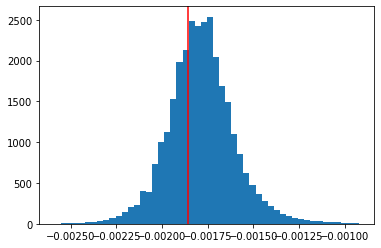

In [38]:
pars = prior2.sample(100000)
lnL = re2.lnL(obs0, pars)
plt.hist(pars['A'], weights = np.exp(lnL[('A',)]), bins = 50, density = True);
plt.axvline(par0['A'], color='r')

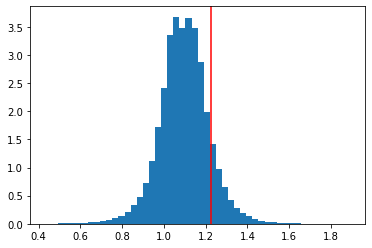

In [39]:
plt.hist(pars['B'], weights = np.exp(lnL[('B',)]), bins = 50, density = True);
plt.axvline(par0['B'], color='r')

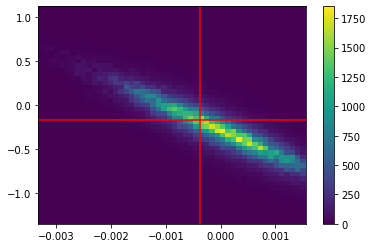

In [28]:
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B',)]), bins = 50, density = True);
plt.axhline(par0['B'], color='r')
plt.axvline(par0['A'], color='r')
plt.colorbar()
#plt.axvline(par0['B'], color='r')